In [1]:
# from tqdm import tqdm
from tqdm.notebook import tqdm

import json 
import pandas as pd
import polars as pl
import unicodedata

import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

In [2]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float16)  # or long, depending on your task
       
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
val = torch.load("../data/2_training_ready/mymethod/take00/val.pt")

/tmp/ipykernel_10371/4087980410.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val = torch.load("../data/2_training_ready/mymethod/take00/val.pt")


In [4]:
testing = torch.load("../data/2_training_ready/mymethod/take00/testing.pt")

/tmp/ipykernel_10371/669655271.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testing = torch.load("../data/2_training_ready/mymethod/take00/testing.pt")


In [5]:
training1 = torch.load("../data/2_training_ready/mymethod/take00/training1.pt")
training2 = torch.load("../data/2_training_ready/mymethod/take00/training2.pt")
training3 = torch.load("../data/2_training_ready/mymethod/take00/training3.pt")
training4 = torch.load("../data/2_training_ready/mymethod/take00/training4.pt")

/tmp/ipykernel_10371/4131447330.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training1 = torch.load("../data/2_training_ready/mymethod/take00/training1.pt")
/tmp/ipyk

In [6]:
# # Combine the embeddings and labels
combined_embeddings = torch.cat([training1.X, training2.X, training3.X,training4.X], dim=0)
combined_labels = torch.cat([training1.y, training2.y, training3.y,training4.y], dim=0)
# 
# # Create a new EmbeddingDataset with the combined data
training = EmbeddingDataset(combined_embeddings.numpy(), combined_labels.numpy())

In [7]:
# Combine the embeddings and labels
# combined_embeddings = torch.cat([training1.X, training2.X, training3.X], dim=0)
# combined_labels = torch.cat([training1.y, training2.y, training3.y], dim=0)

# Create a new EmbeddingDataset with the combined data
# training = EmbeddingDataset(combined_embeddings.numpy(), combined_labels.numpy())

In [8]:
# OG 
# class SimpleNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(SimpleNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             # nn.ReLU(),
#             # nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, output_dim)
#         )
# 
#     def forward(self, x):
#         return self.model(x)

In [9]:
# class SimpleNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(SimpleNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(hidden_dim, output_dim)
#         )
# 
#     def forward(self, x):
#         return self.model(x)

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim=4096, hidden_dim_1=2048,hidden_dim_2=1_024, output_dim=5, dropout=0.1):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.LayerNorm(hidden_dim_1),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            # nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.LayerNorm(hidden_dim_2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim_2, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [8]:
# Set up your dataset and dataloaders
batch_size = 256
train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)


In [9]:
# Convert dataset labels to integers (class indices)
training.y = training.y.long()  # Keep 1-based indexing for star ratings
testing.y = testing.y.long()  # Keep 1-based indexing for star ratings
val.y = val.y.long()

In [10]:
# Define model, loss function, and optimizer
input_dim = training.X.shape[1]  # Number of features in the embeddings
hidden_dim = 2048
output_dim = len(torch.unique(training.y))  # Number of classes

model = SimpleNN(input_dim, hidden_dim, output_dim).to("cuda")
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.631)

In [14]:
# Training and evaluation loops
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to("cuda")
            y = y.to("cuda")
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted + 1 == y).sum().item()  # Adjust prediction for 1-based indexing
            total += y.size(0)
    accuracy = correct / total
    return accuracy


In [15]:
# num_epochs = 10
num_epochs = 15
# log_interval = 1_500
log_interval = 500

In [16]:
step = 0

train_losses = []
eval_accuracies = []
learning_rates = []  # New list to track learning rates

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append((epoch, current_lr))
    # learning_rates.append(current_lr)
    
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    running_loss = 0.0

    for X, y in pbar:
        X = X.to("cuda")
        y = y.to("cuda")
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y - 1)  # Shift labels for 0-based indexing during training
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        step += 1

        # Log progress every log_interval steps
        if step % log_interval == 0:
            eval_accuracy = evaluate(model, test_loader)
            eval_accuracies.append((step, eval_accuracy))
            print(f"Step {step}, Loss: {loss.item():.4f}, Eval Accuracy: {eval_accuracy:.4f}")

    train_losses.append(running_loss / len(train_loader))
    scheduler.step()



Epoch 1/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 500, Loss: 1.4203, Eval Accuracy: 0.4865
Step 1000, Loss: 1.2308, Eval Accuracy: 0.6728
Step 1500, Loss: 1.0831, Eval Accuracy: 0.7023
Step 2000, Loss: 1.0607, Eval Accuracy: 0.7025
Step 2500, Loss: 0.9126, Eval Accuracy: 0.6965
Step 3000, Loss: 0.8042, Eval Accuracy: 0.6967


Epoch 2/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 3500, Loss: 0.8138, Eval Accuracy: 0.7090
Step 4000, Loss: 0.7010, Eval Accuracy: 0.7125
Step 4500, Loss: 0.7052, Eval Accuracy: 0.7129
Step 5000, Loss: 0.7577, Eval Accuracy: 0.7218
Step 5500, Loss: 0.7502, Eval Accuracy: 0.7241
Step 6000, Loss: 0.6753, Eval Accuracy: 0.7246
Step 6500, Loss: 0.6525, Eval Accuracy: 0.7198


Epoch 3/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 7000, Loss: 0.7484, Eval Accuracy: 0.7196
Step 7500, Loss: 0.7499, Eval Accuracy: 0.7269
Step 8000, Loss: 0.7363, Eval Accuracy: 0.7267
Step 8500, Loss: 0.6768, Eval Accuracy: 0.7266
Step 9000, Loss: 0.7234, Eval Accuracy: 0.7237
Step 9500, Loss: 0.6114, Eval Accuracy: 0.7291


Epoch 4/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 10000, Loss: 0.7531, Eval Accuracy: 0.7283
Step 10500, Loss: 0.6152, Eval Accuracy: 0.7268
Step 11000, Loss: 0.6452, Eval Accuracy: 0.7306
Step 11500, Loss: 0.6344, Eval Accuracy: 0.7310
Step 12000, Loss: 0.5757, Eval Accuracy: 0.7318
Step 12500, Loss: 0.6954, Eval Accuracy: 0.7312
Step 13000, Loss: 0.6254, Eval Accuracy: 0.7317


Epoch 5/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 13500, Loss: 0.7966, Eval Accuracy: 0.7307
Step 14000, Loss: 0.5861, Eval Accuracy: 0.7329
Step 14500, Loss: 0.6280, Eval Accuracy: 0.7313
Step 15000, Loss: 0.7055, Eval Accuracy: 0.7336
Step 15500, Loss: 0.6567, Eval Accuracy: 0.7331
Step 16000, Loss: 0.5964, Eval Accuracy: 0.7311
Step 16500, Loss: 0.6168, Eval Accuracy: 0.7338


Epoch 6/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 17000, Loss: 0.6877, Eval Accuracy: 0.7330
Step 17500, Loss: 0.6423, Eval Accuracy: 0.7342
Step 18000, Loss: 0.6528, Eval Accuracy: 0.7331
Step 18500, Loss: 0.6298, Eval Accuracy: 0.7345
Step 19000, Loss: 0.6888, Eval Accuracy: 0.7354
Step 19500, Loss: 0.6381, Eval Accuracy: 0.7346


Epoch 7/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 20000, Loss: 0.6908, Eval Accuracy: 0.7337
Step 20500, Loss: 0.6049, Eval Accuracy: 0.7336
Step 21000, Loss: 0.6064, Eval Accuracy: 0.7353
Step 21500, Loss: 0.6131, Eval Accuracy: 0.7354
Step 22000, Loss: 0.5734, Eval Accuracy: 0.7351
Step 22500, Loss: 0.5642, Eval Accuracy: 0.7360
Step 23000, Loss: 0.6658, Eval Accuracy: 0.7352


Epoch 8/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 23500, Loss: 0.7443, Eval Accuracy: 0.7352
Step 24000, Loss: 0.6732, Eval Accuracy: 0.7365
Step 24500, Loss: 0.5419, Eval Accuracy: 0.7359
Step 25000, Loss: 0.5754, Eval Accuracy: 0.7361
Step 25500, Loss: 0.6052, Eval Accuracy: 0.7358
Step 26000, Loss: 0.5747, Eval Accuracy: 0.7362
Step 26500, Loss: 0.6074, Eval Accuracy: 0.7364


Epoch 9/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 27000, Loss: 0.7197, Eval Accuracy: 0.7363
Step 27500, Loss: 0.6632, Eval Accuracy: 0.7366
Step 28000, Loss: 0.6555, Eval Accuracy: 0.7363
Step 28500, Loss: 0.6321, Eval Accuracy: 0.7367
Step 29000, Loss: 0.6746, Eval Accuracy: 0.7367
Step 29500, Loss: 0.5695, Eval Accuracy: 0.7366


Epoch 10/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 30000, Loss: 0.6951, Eval Accuracy: 0.7368
Step 30500, Loss: 0.5718, Eval Accuracy: 0.7369
Step 31000, Loss: 0.6301, Eval Accuracy: 0.7367
Step 31500, Loss: 0.6282, Eval Accuracy: 0.7371
Step 32000, Loss: 0.6561, Eval Accuracy: 0.7366
Step 32500, Loss: 0.5709, Eval Accuracy: 0.7371
Step 33000, Loss: 0.6398, Eval Accuracy: 0.7370


Epoch 11/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 33500, Loss: 0.6962, Eval Accuracy: 0.7370
Step 34000, Loss: 0.6558, Eval Accuracy: 0.7369
Step 34500, Loss: 0.6428, Eval Accuracy: 0.7372
Step 35000, Loss: 0.5508, Eval Accuracy: 0.7367
Step 35500, Loss: 0.6055, Eval Accuracy: 0.7363
Step 36000, Loss: 0.5924, Eval Accuracy: 0.7371
Step 36500, Loss: 0.6006, Eval Accuracy: 0.7373


Epoch 12/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 37000, Loss: 0.7534, Eval Accuracy: 0.7372
Step 37500, Loss: 0.6168, Eval Accuracy: 0.7374
Step 38000, Loss: 0.6560, Eval Accuracy: 0.7373
Step 38500, Loss: 0.7098, Eval Accuracy: 0.7374
Step 39000, Loss: 0.5672, Eval Accuracy: 0.7375
Step 39500, Loss: 0.6443, Eval Accuracy: 0.7373


Epoch 13/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 40000, Loss: 0.6430, Eval Accuracy: 0.7374
Step 40500, Loss: 0.6420, Eval Accuracy: 0.7373
Step 41000, Loss: 0.6018, Eval Accuracy: 0.7375
Step 41500, Loss: 0.5842, Eval Accuracy: 0.7371
Step 42000, Loss: 0.6441, Eval Accuracy: 0.7374
Step 42500, Loss: 0.5719, Eval Accuracy: 0.7371
Step 43000, Loss: 0.5961, Eval Accuracy: 0.7371


Epoch 14/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 43500, Loss: 0.7777, Eval Accuracy: 0.7374
Step 44000, Loss: 0.5440, Eval Accuracy: 0.7375
Step 44500, Loss: 0.6689, Eval Accuracy: 0.7375
Step 45000, Loss: 0.5831, Eval Accuracy: 0.7373
Step 45500, Loss: 0.7439, Eval Accuracy: 0.7376
Step 46000, Loss: 0.6465, Eval Accuracy: 0.7375
Step 46500, Loss: 0.5847, Eval Accuracy: 0.7374


Epoch 15/15:   0%|          | 0/3322 [00:00<?, ?it/s]

Step 47000, Loss: 0.7327, Eval Accuracy: 0.7373
Step 47500, Loss: 0.5702, Eval Accuracy: 0.7374
Step 48000, Loss: 0.7014, Eval Accuracy: 0.7375
Step 48500, Loss: 0.6048, Eval Accuracy: 0.7376
Step 49000, Loss: 0.6154, Eval Accuracy: 0.7375
Step 49500, Loss: 0.6699, Eval Accuracy: 0.7376


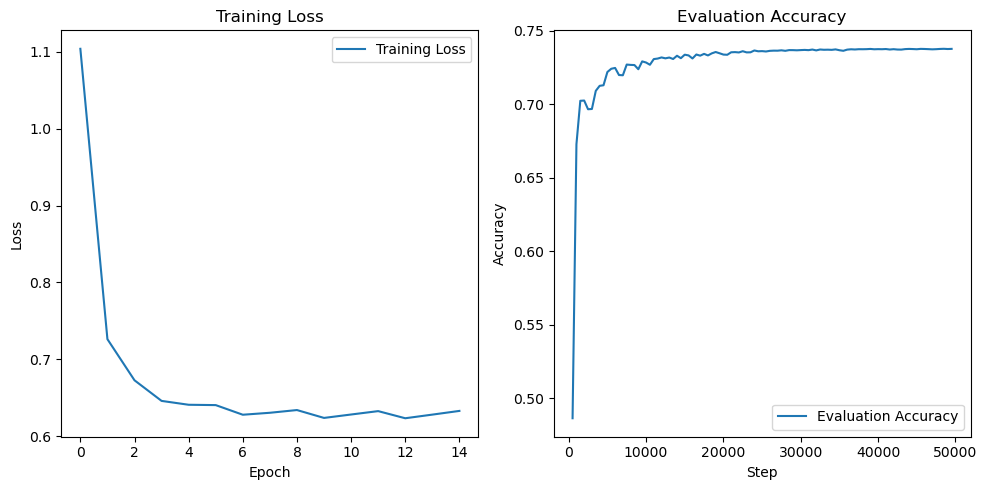

In [17]:
# Plot training loss and evaluation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")

plt.subplot(1, 2, 2)
steps, accuracies = zip(*eval_accuracies)
plt.plot(steps, accuracies, label="Evaluation Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Evaluation Accuracy")

plt.tight_layout()
plt.show()


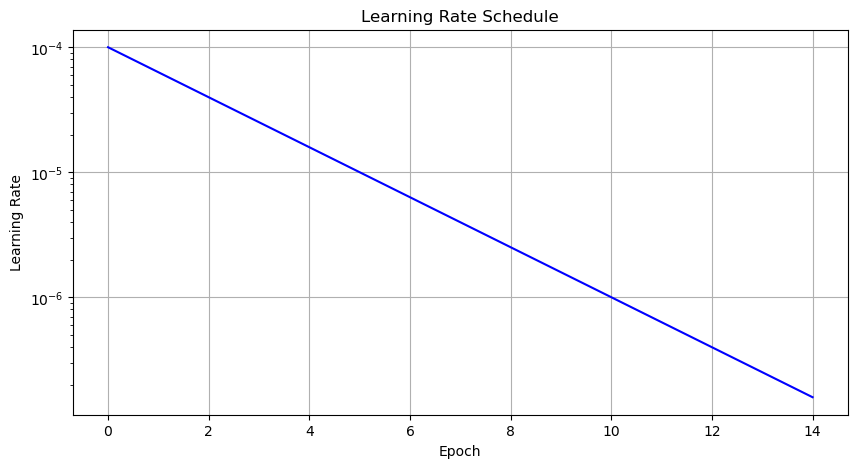

In [18]:
epochs, lrs = zip(*learning_rates)
plt.figure(figsize=(10, 5))
plt.plot(epochs, lrs, 'b-')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [19]:
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
val_accuracy = evaluate(model, val_loader)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 71.22%


In [20]:
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# 
# # Gather all embeddings from the testing dataset into a single tensor
# all_embeddings = []
# for i in range(len(testing)):
#     X, y = testing[i]  # X is embeddings, y is target
#     # Ensure X is a tensor of shape [embedding_dim]
#     # If not, you might need to reshape or extract the embedding part
#     all_embeddings.append(X)
# 
# test_embeddings = torch.stack(all_embeddings, dim=0)  # Shape: (N, D)
# 
# # Compute per-dimension means and variances
# dimension_means = test_embeddings.mean(dim=0)
# dimension_vars = test_embeddings.var(dim=0, unbiased=False)
# 
# print("Mean of means:", dimension_means.mean().item())
# print("Mean of variances:", dimension_vars.mean().item())
# 
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.hist(dimension_means.cpu().numpy(), bins=50, color='skyblue', edgecolor='black')
# plt.title("Distribution of Per-Dimension Means")
# plt.xlabel("Mean Value")
# plt.ylabel("Frequency")
# 
# plt.subplot(1,2,2)
# plt.hist(dimension_vars.cpu().numpy(), bins=50, color='lightgreen', edgecolor='black')
# plt.title("Distribution of Per-Dimension Variances")
# plt.xlabel("Variance Value")
# plt.ylabel("Frequency")
# 
# plt.tight_layout()
# plt.show()
